#  Вебинар 5. Пайплайн исследования данных. Интерпретация моделей для бизнеса
Домашнее задание:  

Вам предстоит решить типичную для продуктовой аналитики задачу прогноза LTV пользователя. Для этого необходимо:  
1) провести исследовательский анализ данных,
2) визуализировать результаты и сделать из них выводы,
3) провести предобработку признаков (возможно создать новые),
4) обучить модели, и подобрать для каждой из них оптимальные гиперпараметры,
5) оценить работу моделей и сравнить их между собой, выбрать итоговую и объяснить свой выбор,
6) проинтерпретировать получившиеся результаты (что и как влияет на LTV пользователя).  

Данные:  

В файле LTV.csv представлены данные о пользователях с автомобильной страховкой, собранных системой аналитики компании IBM. https://www.ibm.com/communities/analytics/watson-analytics-blog/marketing-customer-value-analysis/

Описание данных:  
- Customer - идентификатор пользователя
- State - штат
- Customer Lifetime Value - LTV пользователя
- Response - взаимодействие с рекламой
- Coverage - тип страхового покрытия
- Education - образование
- Effective to date - срок действия страховки
- EmploymentStatus - трудоустройство
- Gender - пол
- Income - доход
- Location code - тип местности в которой проживает пользователь
- Marital Status - семейное положение
- Monthly Premium Auto - Ежемесячный Премиум Авто
- Months Since Last Claim - месяцев с последнего требования по выплате компенсации
- Months Since Policy Inception - месяцев с открытия страховки
- Number of Open Complaints - количество незакрытых жалоб
- Number of Policies - количество полисов
- Policy Type - тип страховки
- Policy - страховка
- Renew Offer Type - обновленный тип предложения
- Sales Channel - канал продаж
- Total Claim Amount - сумма выплаченных компенсаций
- Vehicle Class - класс автомобиля
- Vehicle Size - размер автомобиля

In [118]:
# Устанавливаем пакеты если они не установлены
# !pip install pandas
# !pip install matplotlib
# !pip install seaborn
# !pip install scipy
# !pip install -U scikit-learn

In [119]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
# Запрещаем вывод на экран предупреждений
warnings.filterwarnings('ignore')
# Настройка формата вывода чисел float
pd.set_option('display.float_format', '{:_.2f}'.format)
import numpy as np
# Вычисление Z-score
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from scipy.stats.mstats import winsorize

## Загрузка данных

### Загружаем дадасет

In [120]:
# Загрузим датасет пропуская сбойные строки
train_data = pd.read_csv('./LTV.csv', engine='python', on_bad_lines='skip')

### Посмотрим количество строк, столбцов

In [121]:
train_data.shape

(9134, 24)

### Посмотрим, что за данные

In [122]:
# Укажем в настройках, чтобы отображались все столбцы
pd.set_option('display.max_columns', None)
train_data.head()

,Customer,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,Location Code,Marital Status,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
0,BU79786,Washington,2_763.52,No,Basic,Bachelor,2/24/11,Employed,F,56274,Suburban,Married,69,32,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.81,Two-Door Car,Medsize
1,QZ44356,Arizona,6_979.54,No,Extended,Bachelor,1/31/11,Unemployed,F,0,Suburban,Single,94,13,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1_131.46,Four-Door Car,Medsize
2,AI49188,Nevada,12_887.43,No,Premium,Bachelor,2/19/11,Employed,F,48767,Suburban,Married,108,18,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.47,Two-Door Car,Medsize
3,WW63253,California,7_645.86,No,Basic,Bachelor,1/20/11,Unemployed,M,0,Suburban,Married,106,18,65,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.88,SUV,Medsize
4,HB64268,Washington,2_813.69,No,Basic,Bachelor,2/3/11,Employed,M,43836,Rural,Single,73,12,44,0,1,Personal Auto,Personal L1,Offer1,Agent,138.13,Four-Door Car,Medsize


In [123]:
# Вернем настройки в первоначальное состояние
pd.reset_option('display.max_columns')

### Информация о датафрейме

In [124]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9134 entries, 0 to 9133
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Customer                       9134 non-null   object 
 1   State                          9134 non-null   object 
 2   Customer Lifetime Value        9134 non-null   float64
 3   Response                       9134 non-null   object 
 4   Coverage                       9134 non-null   object 
 5   Education                      9134 non-null   object 
 6   Effective To Date              9134 non-null   object 
 7   EmploymentStatus               9134 non-null   object 
 8   Gender                         9134 non-null   object 
 9   Income                         9134 non-null   int64  
 10  Location Code                  9134 non-null   object 
 11  Marital Status                 9134 non-null   object 
 12  Monthly Premium Auto           9134 non-null   i

### Проверка пустых значений

In [125]:
# Настроим pd, чтобы выводились все строки 
pd.set_option('display.max_rows', None)
# Проверка того, в каких столбцах отсутствуют значения
print(train_data.isnull().sum(axis=0))
# Сбросим настройки вывода строк
pd.reset_option('display.max_rows')

Customer                         0
State                            0
Customer Lifetime Value          0
Response                         0
Coverage                         0
Education                        0
Effective To Date                0
EmploymentStatus                 0
Gender                           0
Income                           0
Location Code                    0
Marital Status                   0
Monthly Premium Auto             0
Months Since Last Claim          0
Months Since Policy Inception    0
Number of Open Complaints        0
Number of Policies               0
Policy Type                      0
Policy                           0
Renew Offer Type                 0
Sales Channel                    0
Total Claim Amount               0
Vehicle Class                    0
Vehicle Size                     0
dtype: int64


### Проверка дубликатов

In [126]:
# Посмотрим сколько у нас дубликатов
duplicates = train_data.duplicated()
duplicates_train_data = train_data[duplicates]
duplicates_train_data

,Customer,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,...,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size


### Краткий отчет по датафрейму

In [127]:
train_data.describe()

,Customer Lifetime Value,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount
count,9_134.00,9_134.00,9_134.00,9_134.00,9_134.00,9_134.00,9_134.00,9_134.00
mean,8_004.94,37_657.38,93.22,15.10,48.06,0.38,2.97,434.09
std,6_870.97,30_379.90,34.41,10.07,27.91,0.91,2.39,290.50
min,1_898.01,0.00,61.00,0.00,0.00,0.00,1.00,0.10
25%,3_994.25,0.00,68.00,6.00,24.00,0.00,1.00,272.26
50%,5_780.18,33_889.50,83.00,14.00,48.00,0.00,2.00,383.95
75%,8_962.17,62_320.00,109.00,23.00,71.00,0.00,4.00,547.51
max,83_325.38,99_981.00,298.00,35.00,99.00,5.00,9.00,2_893.24


## Визуализация данных
[Руководство по subplots в matplotlib](https://teletype.in/@pythontalk/matplotlib_subplot_tutorial)  
[Визуализация данных в Seaborn](https://nagornyy.me/it/vizualizatsiia-dannykh-v-seaborn/)

### Выделим матрицу признаков и вектор с целевой переменной в тренировочной выборке

In [128]:
# Тренировочная выборка
X = train_data.drop('Customer Lifetime Value', axis = 1)
# Целевая переменная
y = pd.DataFrame(train_data['Customer Lifetime Value'])

### Выделим численные признаки от остальных

In [129]:
num_cols = []
str_cols = []

cols_and_type = X.dtypes.to_dict()

for col in cols_and_type:
    if cols_and_type[col] in ('int64', 'float64'):
        num_cols.append(col)
    else: 
        str_cols.append(col)
        
print(num_cols)

['Income', 'Monthly Premium Auto', 'Months Since Last Claim', 'Months Since Policy Inception', 'Number of Open Complaints', 'Number of Policies', 'Total Claim Amount']


In [130]:
# Словарь название столбца и тип данных
cols_and_type

{'Customer': dtype('O'),
 'State': dtype('O'),
 'Response': dtype('O'),
 'Coverage': dtype('O'),
 'Education': dtype('O'),
 'Effective To Date': dtype('O'),
 'EmploymentStatus': dtype('O'),
 'Gender': dtype('O'),
 'Income': dtype('int64'),
 'Location Code': dtype('O'),
 'Marital Status': dtype('O'),
 'Monthly Premium Auto': dtype('int64'),
 'Months Since Last Claim': dtype('int64'),
 'Months Since Policy Inception': dtype('int64'),
 'Number of Open Complaints': dtype('int64'),
 'Number of Policies': dtype('int64'),
 'Policy Type': dtype('O'),
 'Policy': dtype('O'),
 'Renew Offer Type': dtype('O'),
 'Sales Channel': dtype('O'),
 'Total Claim Amount': dtype('float64'),
 'Vehicle Class': dtype('O'),
 'Vehicle Size': dtype('O')}

### Создадим словарь признаков и их русский перевод

In [131]:
# Словарь признаков и их русский перевод
translate_col = {
'Customer': 'идентификатор пользователя',
'State': 'штат',
'Customer Lifetime Value': 'LTV пользователя',
'Response': 'взаимодействие с рекламой',
'Coverage': 'тип страхового покрытия',
'Education': 'образование',
'Effective To Date': 'срок действия страховки',
'EmploymentStatus': 'трудоустройство',
'Gender': 'пол',
'Income': 'доход',
'Location Code': 'тип местности в которой проживает пользователь',
'Marital Status': 'семейное положение',
'Monthly Premium Auto': 'Ежемесячный Премиум Авто',
'Months Since Last Claim': 'месяцев с последнего \n требования по выплате компенсации',
'Months Since Policy Inception': 'месяцев с открытия страховки',
'Number of Open Complaints': 'количество незакрытых жалоб',
'Number of Policies': 'количество полисов',
'Policy Type': 'тип страховки',
'Policy': 'страховка',
'Renew Offer Type': 'обновленный тип предложения',
'Sales Channel': 'канал продаж',
'Total Claim Amount': 'сумма выплаченных компенсаций',
'Vehicle Class': 'класс автомобиля',
'Vehicle Size': 'размер автомобиля'
}

### Визуализируем распределение числовых признаков

In [132]:
def visualization_numerical_characteristics():
    '''
    Визуализация цифровых признаков (так сделал, чтобы код в одном месте находился).
    '''
    plt.figure(figsize=[14, 13])

    # Общий заголовок для всех графиков
    plt.suptitle('Распределение числовых признаков', 
                  y=1.005, 
                  fontsize=19, 
                  fontweight='bold')

    for i, col in enumerate(num_cols):
        plt.subplot(3, 3, i+1)
        # Заголовок для графика
        plt.title(f'\n{col} \n({translate_col[col]})', fontsize=10)
        # Задаём размер шривта и угол поворота текста для осей X и Y
        plt.xticks(fontsize=8)
        plt.yticks(fontsize=8)
        # Делаем размер шрифта по Y=5, не уберая название оси
        plt.ylabel('', fontsize=5)
        # Отрисовываем гистограмму
        sns.histplot(train_data[col])

    # Автоматически уместить все элементы на полотне    
    plt.tight_layout()

    # Вывести графики на экран
    plt.show()

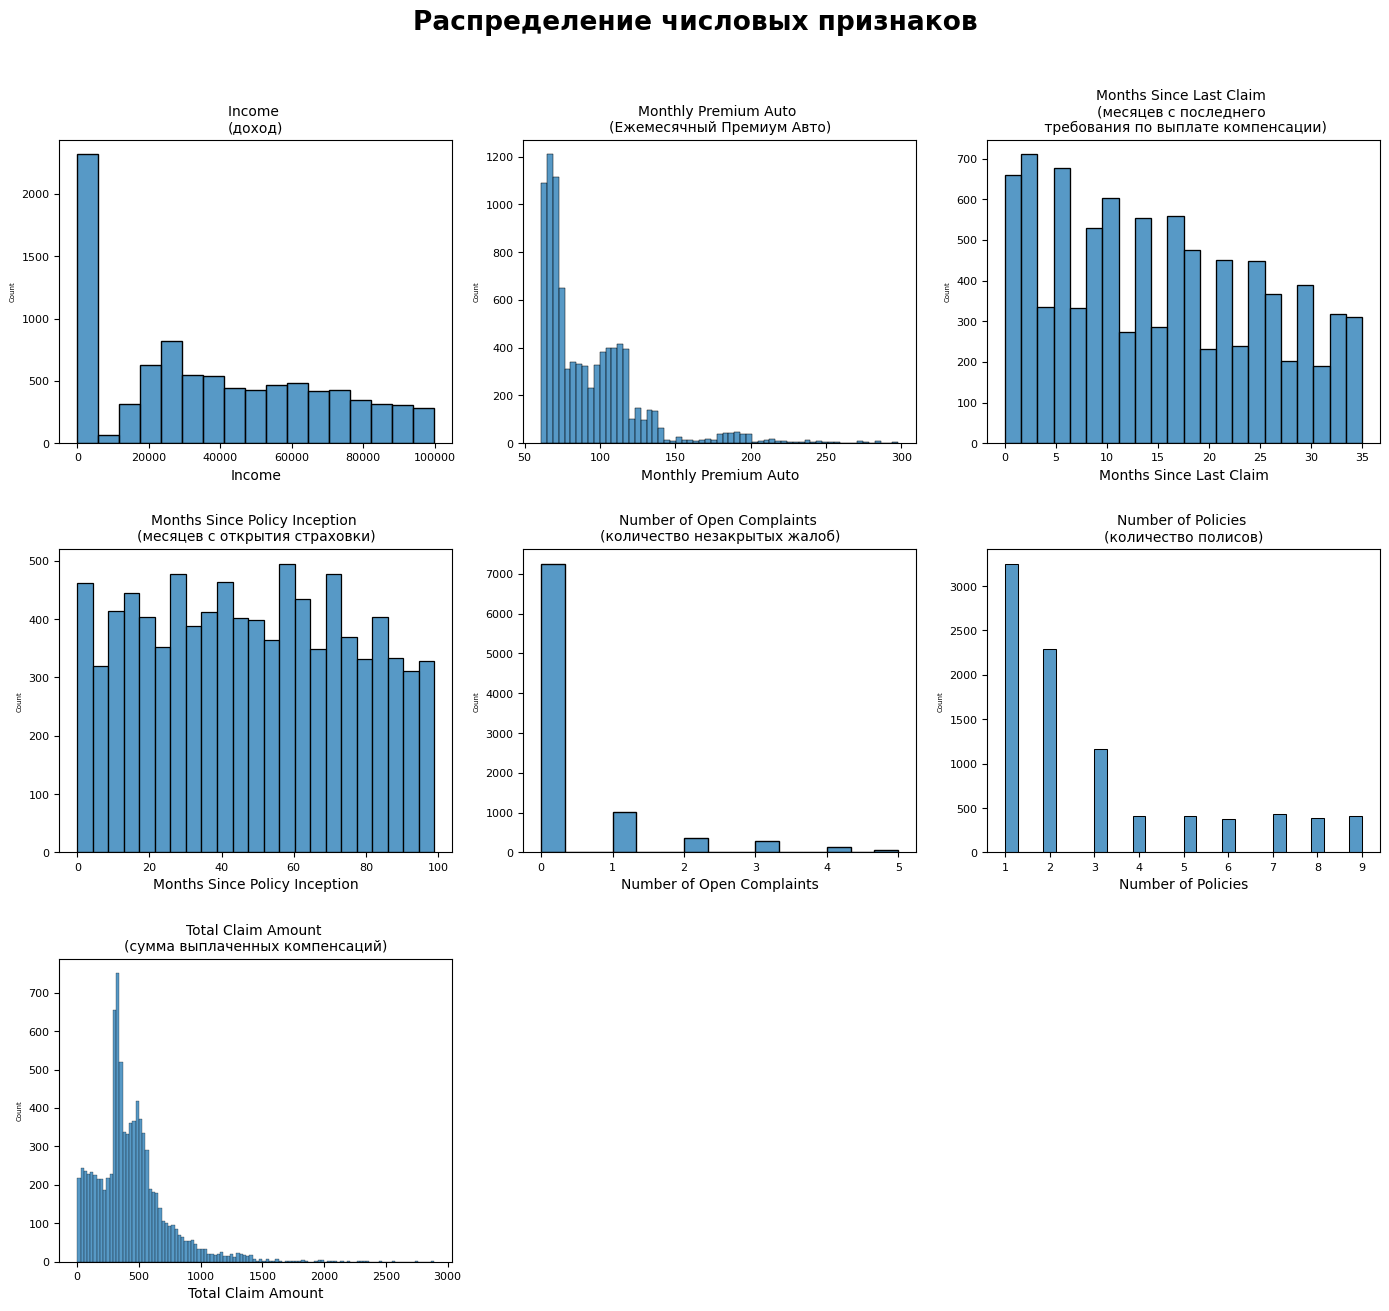

In [133]:
visualization_numerical_characteristics()

### Визуализируем распределение целевой переменной

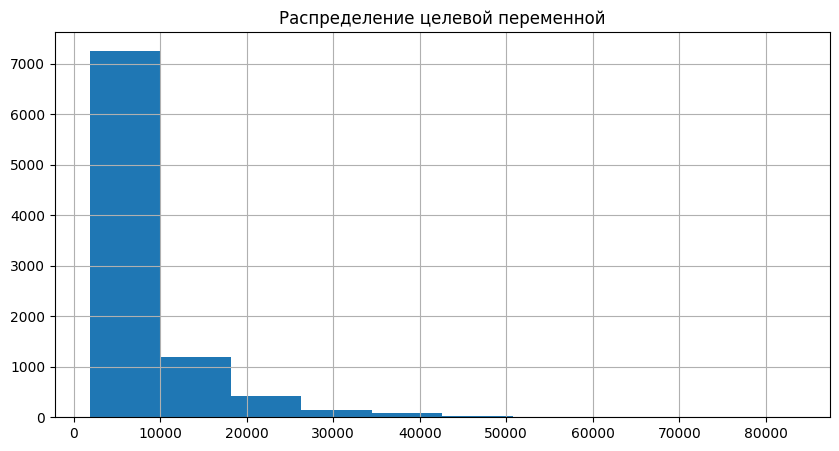

In [134]:
plt.figure(figsize = (10, 5))
plt.title('Распределение целевой переменной')
train_data['Customer Lifetime Value'].hist()

plt.show()

### Визуализируем распределение строковых признаков

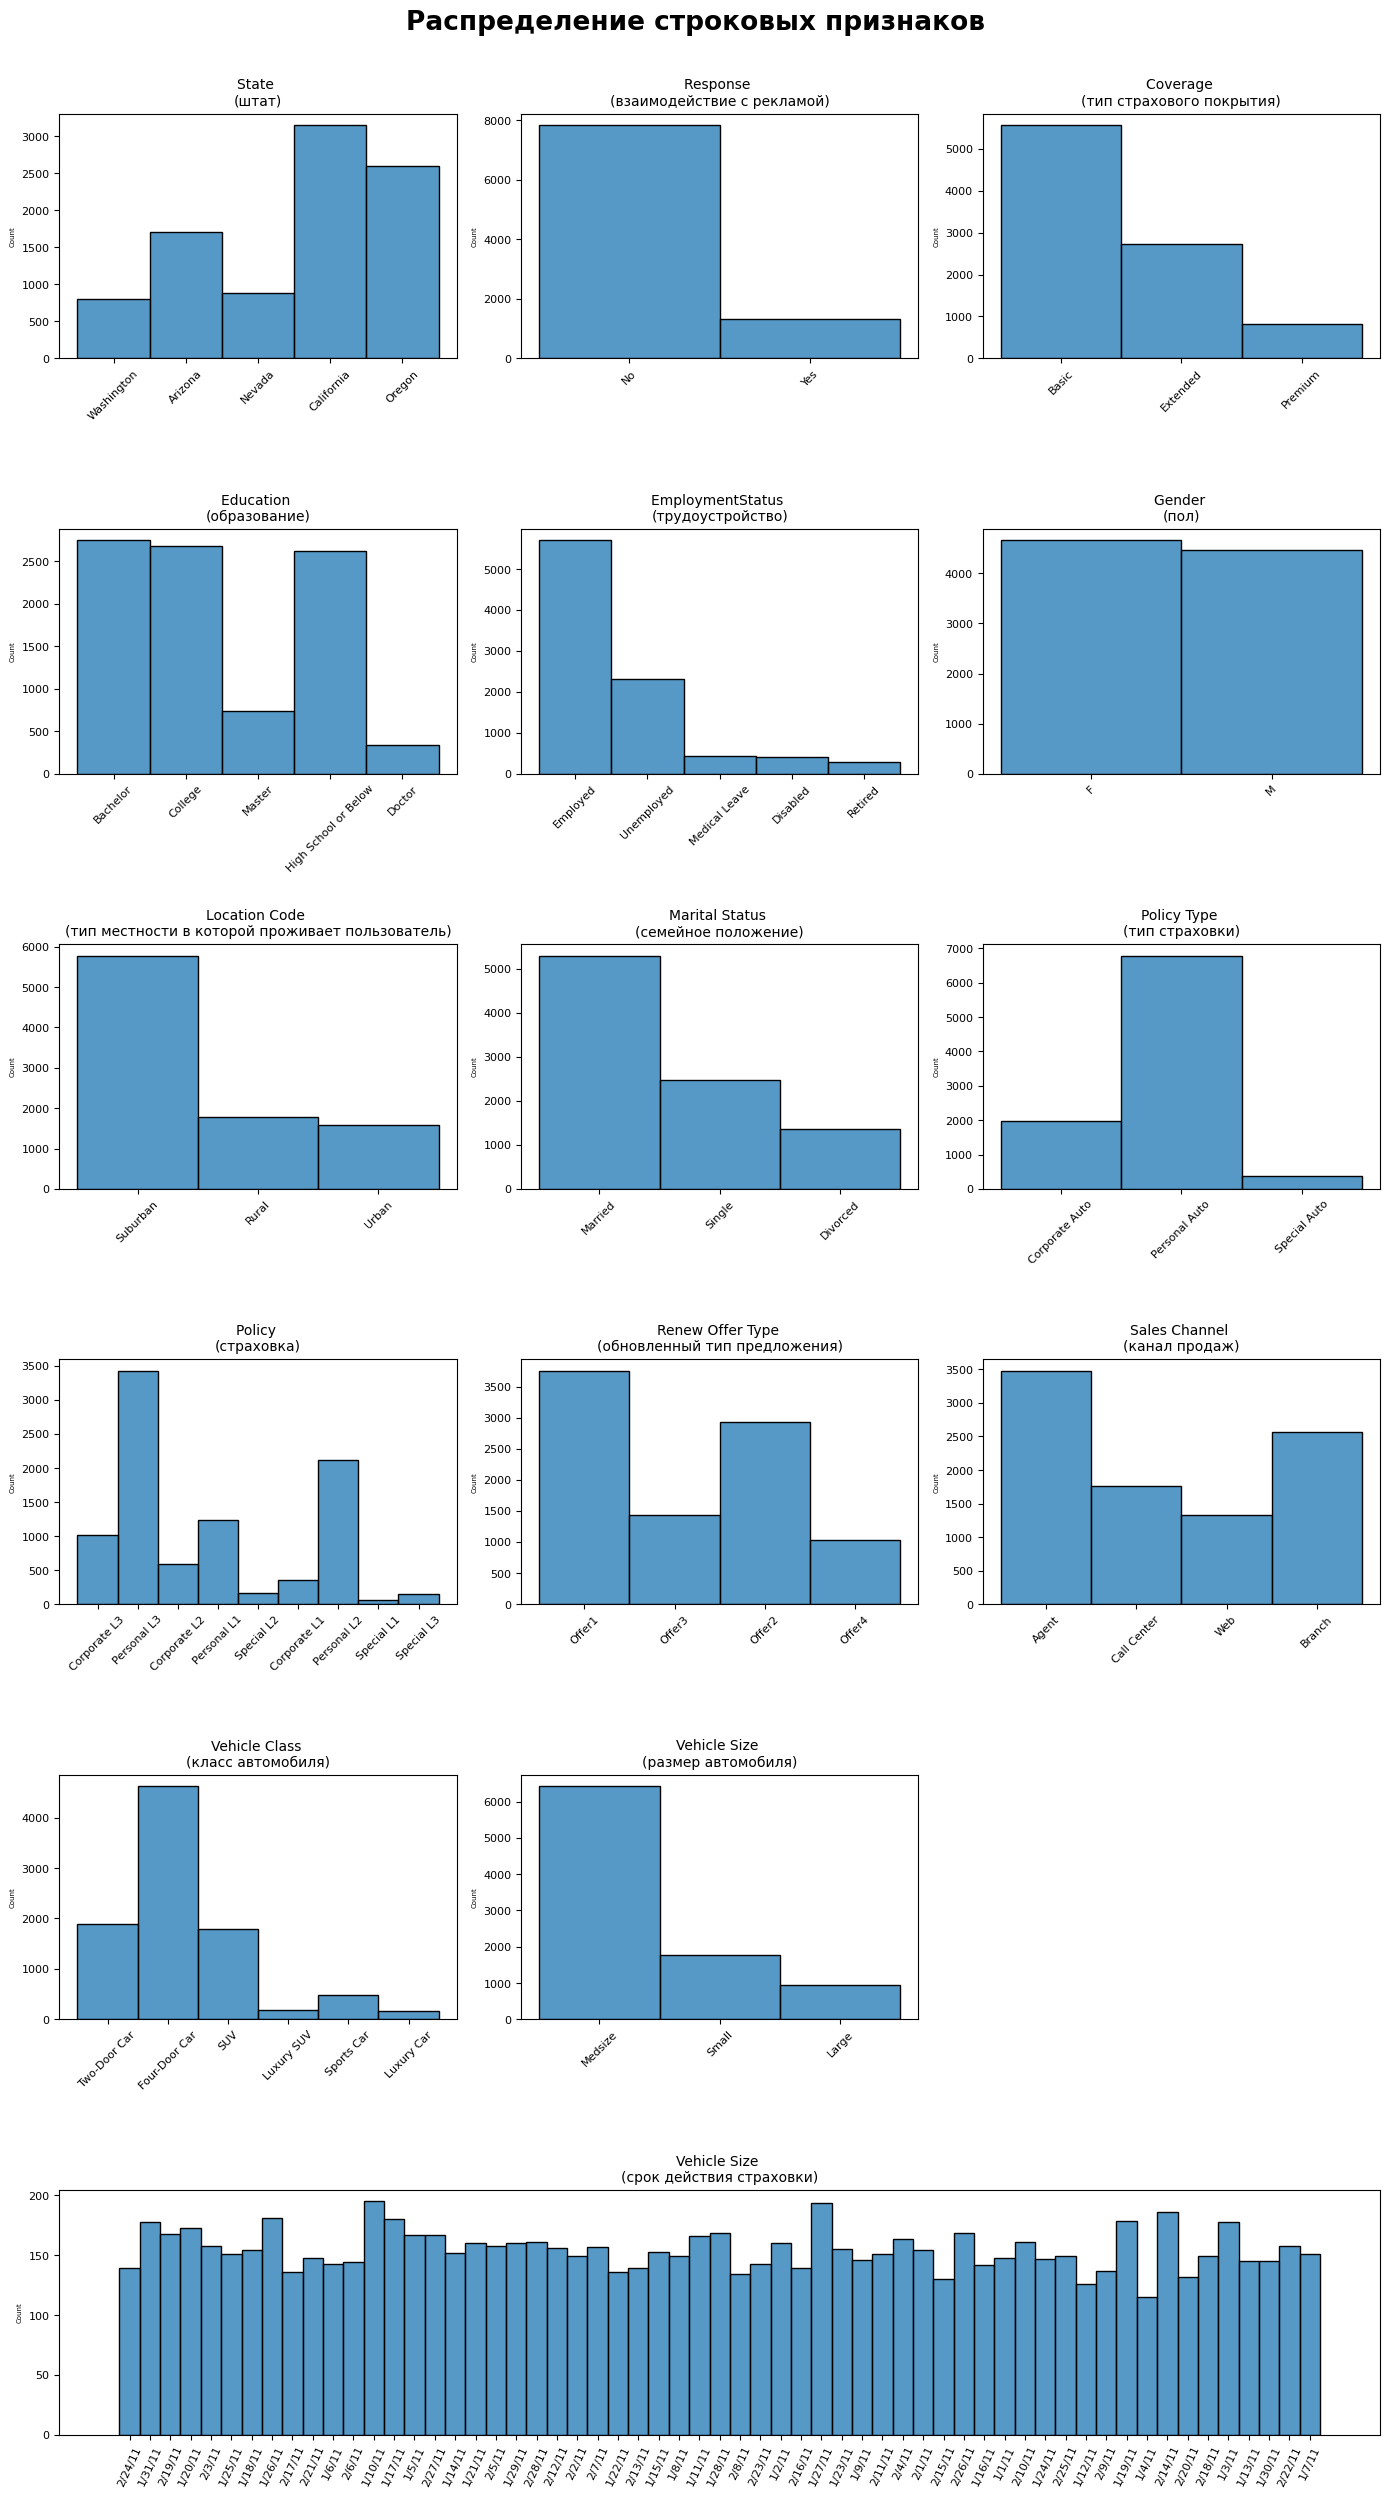

In [135]:
# Задаём размеры полотна [ширина, длина]
plt.figure(figsize=[14, 25])

# Общий заголовок для всех графиков
plt.suptitle('Распределение строковых признаков', 
              y=1.005, 
              fontsize=19, 
              fontweight='bold')
index_plt = 0
# Добавляем графики на полотно (3 шт. в одном ряду)
for col in str_cols:
    if not col in ['Customer', 'Effective To Date']:
        plt.subplot(6, 3, index_plt+1)
        # Заголовок для графика
        plt.title(f'{col} \n({translate_col[col]})', fontsize=10)
        # Задаём размер шривта и угол поворота текста для осей X и Y
        plt.xticks(rotation=45, fontsize=8)
        plt.yticks(fontsize=8)
        # Убираем подпись оси X
        plt.xlabel(' ')
        # Делаем размер шрифта по Y=5, не уберая название оси
        plt.ylabel('', fontsize=5)
        # Отрисовываем гистограмму
        sns.histplot(train_data[col])
        index_plt += 1

# Автоматически уместить все элементы на полотне    
plt.tight_layout()

# График во всю длину экрана
plt.subplot(6, 1, 6)
# Заголовок для графика
plt.title(f'{col} \n({translate_col["Effective To Date"]})', fontsize=10)
# Задаём размер шривта и угол поворота текста для осей X и Y
plt.xticks(rotation=65, fontsize=8)
plt.yticks(fontsize=8)
# Убираем подпись оси X
plt.xlabel(' ')
# Делаем размер шрифта по Y=5, не уберая название оси
plt.ylabel('', fontsize=5)
# Отрисовываем гистограмму
sns.histplot(train_data['Effective To Date'])
        
# Автоматически уместить все элементы на полотне    
plt.tight_layout()

# Вывести графики на экран
plt.show()

## Предобработка признаков

### Посмотрим какие признаки имеют выбросы

In [136]:
def emission_test(ds, col_test, threshold_val=3):
    '''
    Функция проводит тестирование столбцов на выбросы методом Z-score.
    
    :param ds: исследуемый датасет,
    :param col_test: список, колонок,
    :param threshold_val: пороговое значение Z-score,
    :return: результат исследования.
    '''
    result = ''
    for col in col_test:
        # Вычисление Z-score
        z = np.abs(stats.zscore(ds[col]))
        # Установка порогового значения Z-score
        threshold = 3
        # Выявление выбросов на основе Z-score
        outliers = ds[col][z > threshold]

        if len(outliers) > 0:
            result += f'В столбце {col}, {len(outliers)} выбросов. Среднее по столбцу {ds[col].mean()}\n'
    
    
    return 'Выбросов нет.' if result == '' else result

In [137]:
# Выведем признаки которые имеют выбросы
print(emission_test(ds=X, col_test=num_cols))

В столбце Monthly Premium Auto, 200 выбросов. Среднее по столбцу 93.21929056273265
В столбце Number of Open Complaints, 205 выбросов. Среднее по столбцу 0.38438800087584846
В столбце Total Claim Amount, 158 выбросов. Среднее по столбцу 434.0887943128969



### Уберём выбросы в выбранных признаках, с помощью логорифмической функции

В столбце Monthly Premium Auto, 103 выбросов. Среднее по столбцу 4.494058343737844
В столбце Number of Open Complaints, 205 выбросов. Среднее по столбцу 0.38438800087584846
В столбце Total Claim Amount, 181 выбросов. Среднее по столбцу 5.797730899575215



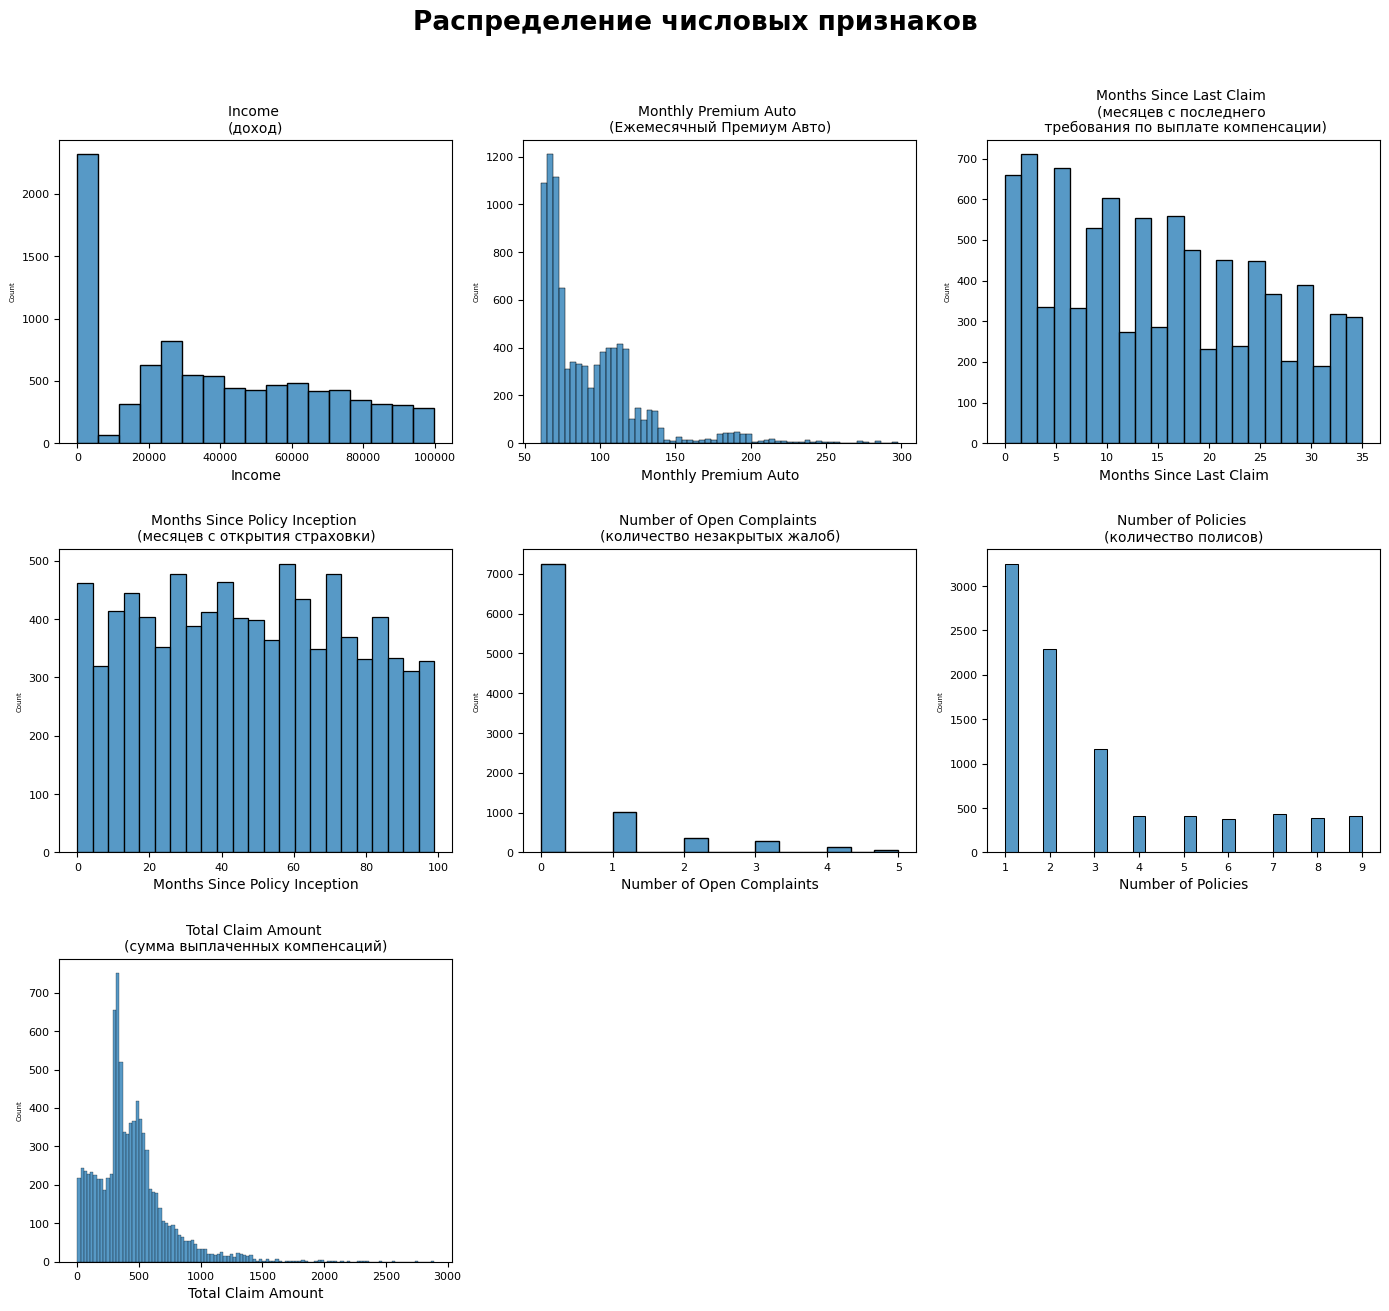

In [138]:
# Оставил этот код, чтобы не забыть методы борьбы с выбросами

# # Уберём выбросы в дву столбцах, с помощью винсоризации
# X['Monthly Premium Auto'] = winsorize(X['Monthly Premium Auto'], limits=[0.05, 0.05])
# X['Total Claim Amount'] = winsorize(X['Total Claim Amount'], limits=[0.05, 0.05])

# # Уберём выбросы заменив экстримальные значения на медиану
# # Вычисление Z-score
# z = np.abs(stats.zscore(X['Number of Open Complaints']))
# # Установка порогового значения Z-score
# threshold = 3
# # Замена выбрасов медианным значением
# X.loc[z > threshold, 'Number of Open Complaints'] = X['Number of Open Complaints'].median()

# Уберём выбросы в выбранных признаках, с помощью логорифмической функции
X['Monthly Premium Auto'] = np.log1p(X['Monthly Premium Auto'])
X['Total Claim Amount'] = np.log1p(X['Total Claim Amount'])

# Выведем признаки которые имеют выбросы
print(emission_test(ds=X, col_test=num_cols))

# Визуализируем данные
visualization_numerical_characteristics()

### Посмотрим выбросы в целевой переменной

In [139]:
# Выведем признаки которые имеют выбросы
emission_test(ds=y, col_test=['Customer Lifetime Value'])

'В столбце Customer Lifetime Value, 211 выбросов. Среднее по столбцу 8004.940474987081\n'

### Удалим выбросы с помощью логорифмической функции

In [140]:
y['Customer Lifetime Value'] = np.log1p(y['Customer Lifetime Value'])
# Выведем признаки которые имеют выбросы
emission_test(ds=y, col_test=['Customer Lifetime Value'])

'В столбце Customer Lifetime Value, 32 выбросов. Среднее по столбцу 8.748753196029405\n'

### Переведём строковые признаки в числовые

In [141]:
le = LabelEncoder()
# Пробежимся по столбцам датафрейма и преобразуем буквеное обозначение в цифровое
for col in str_cols:
    X[col] = le.fit_transform(X[col].astype(str))

In [142]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9134 entries, 0 to 9133
Data columns (total 23 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Customer                       9134 non-null   int32  
 1   State                          9134 non-null   int32  
 2   Response                       9134 non-null   int32  
 3   Coverage                       9134 non-null   int32  
 4   Education                      9134 non-null   int32  
 5   Effective To Date              9134 non-null   int32  
 6   EmploymentStatus               9134 non-null   int32  
 7   Gender                         9134 non-null   int32  
 8   Income                         9134 non-null   int64  
 9   Location Code                  9134 non-null   int32  
 10  Marital Status                 9134 non-null   int32  
 11  Monthly Premium Auto           9134 non-null   float64
 12  Months Since Last Claim        9134 non-null   i

### Посмотрим корреляцию признаков

In [143]:
corr_matrix = X.corr()
corr_matrix = np.round(corr_matrix, 1)
corr_matrix[np.abs(corr_matrix)<0.3] = 0

# Укажем в настройках, чтобы отображались все столбцы
pd.set_option('display.max_columns', None)
corr_matrix

,Customer,State,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,Location Code,Marital Status,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
Customer,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
State,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Response,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Coverage,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.50,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Education,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Effective To Date,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
EmploymentStatus,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,-0.70,0.00,0.30,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.30,0.00,0.00
Gender,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Income,0.00,0.00,0.00,0.00,0.00,0.00,-0.70,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.30,0.00,0.00
Location Code,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.50,0.00,0.00


In [144]:
# Вернем настройки в первоначальное состояние
pd.reset_option('display.max_columns')

Text(0.5, 1.0, 'График корреляции')

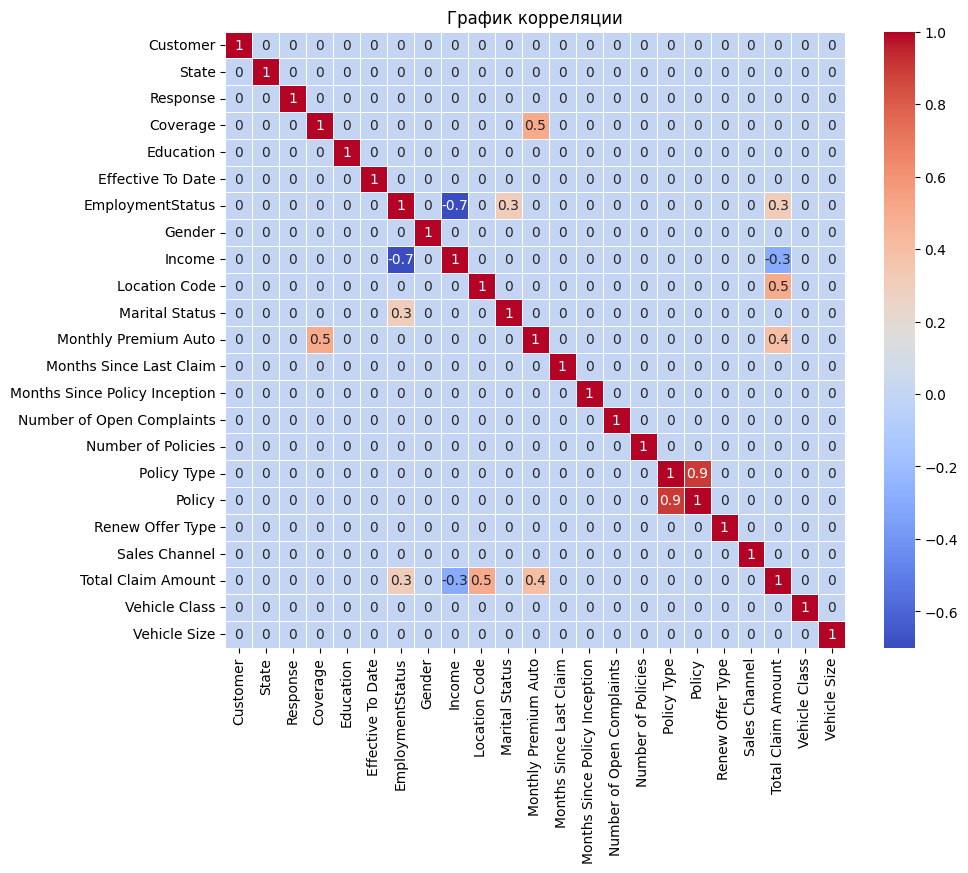

In [145]:
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, linewidths=0.5, cmap='coolwarm')
plt.title('График корреляции')

### Удалим не нужные столбцы

In [146]:
# Удалим поле 'Customer' (id пользователя)
X = X.drop('Customer', axis = 1)

## Обучение различных моделей
[Линейные модели](https://scikit-learn.ru/1-1-linear-models/#ordinary-least-squares)  
[Кросс-валидация](https://scikit-learn.ru/3-1-cross-validation-evaluating-estimator-performance/)

### Линейная регрессия

In [147]:
# Линейная регрессия
from sklearn.linear_model import LinearRegression

# Кросс-валидация 
from sklearn.model_selection import cross_validate

line_reg = LinearRegression()
cv_line_reg = cross_validate(line_reg, X, y, cv = 5)
print("Результат Линейной регрессии:", sum(cv_line_reg['test_score']) / len(cv_line_reg['test_score']))

Результат Линейной регрессии: 0.2584134453365551


### Лассо модель

In [148]:
# Лассо модель
from sklearn.linear_model import Lasso

lasso_reg = Lasso(alpha=0.1)
cv_lasso_reg = cross_validate(lasso_reg, X, y, cv = 5)
print("Результат Лассо регрессии:", sum(cv_line_reg['test_score']) / len(cv_line_reg['test_score']))

Результат Лассо регрессии: 0.2584134453365551


### Регрессия Хуберта
[Полезная ссылка](https://dzen.ru/a/X_HP1v5OaG9q6VlX)

In [149]:
# Регрессия Хуберта
from sklearn.linear_model import HuberRegressor

huber_reg = HuberRegressor()
cv_huber_reg = cross_validate(huber_reg, X, y, cv = 5)
print("Результат регрессии Хуберта:", sum(cv_huber_reg['test_score']) / len(cv_huber_reg['test_score']))

Результат регрессии Хуберта: -3.1012947417781342


### Регрессия Байесовского хребта  
[Обратное преобразование log1p](https://stackoverflow.com/questions/50049891/what-is-the-inverse-of-numpys-log1p)

In [150]:
# Регрессия Байесовского хребта
from sklearn.linear_model import BayesianRidge

bayes_reg = BayesianRidge().fit(X, y)
cv_bayes_reg = cross_validate(bayes_reg, X, y, cv = 5)
print("Результат регрессии Байесовского хребта:", sum(cv_bayes_reg['test_score']) / len(cv_bayes_reg['test_score']))

Результат регрессии Байесовского хребта: 0.25840673732454633


In [151]:
# Попробуем сделать предикт первой строчки датасета
np.expm1(bayes_reg.predict(np.array([X.iloc[0].values])))

array([4807.57938444])

### Вывод:  
Все линейные модели кроме регрессии Хуберта показали одинаковый результат.  
Стандартизация данных:  
```python
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_sc = sc.fit_transform(X)
```
Эффекта не дает, такие же результаты. Мне удалось улучшить результат благодаря удалению выбросов в целевой переменной `y` с помощью логорифмической функции. При предикте нужно будет делать обратное преобразование.  
```python
# Регрессия Байесовского хребта
from sklearn.linear_model import BayesianRidge

bayes_reg = BayesianRidge().fit(X, y)
# Попробуем сделать предикт первой строчки датасета
np.expm1(bayes_reg.predict(np.array([X.iloc[0].values])))
```
Если в моделях задавать дополнительные параметры, результат только хуже. Достоверность модели к сожалению у меня более 25% не повышается.


## Интерпретация модели и важность признаков
[Как интерпретировать предсказания моделей в SHAP](https://habr.com/ru/articles/428213/)  
[SHAP](https://shap-lrjball.readthedocs.io/en/latest/generated/shap.TreeExplainer.html)  
[Интерпретируй это: метод SHAP в Data Science](https://chernobrovov.ru/articles/interpretiruj-eto-metod-shap-v-data-science.html)

### По сколько интерпретация моделей в SNAP работает только на древовидных моделях, единственное что мне пришло голову это посмотреть корреляцию. Код ниже оставил, чтобы не забыть.

In [152]:
# Раскомментируйте чтобы установить 
#!pip install shap

In [153]:
# import shap
# # Загружаем JS шаблоны для визуализации
# shap.initjs()

# # Обязателен явный вызов метода fit
# ran_for.fit(X, y)

# print("Обучили модель, переходим к визуализации")
# # Интерпретируем предсказания модели при помощи SHAP
# explainer = shap.TreeExplainer(ran_for)
# shap_values = explainer.shap_values(X)

In [154]:
# # Общий график
# shap.summary_plot(shap_values, X, plot_type="bar")

### Посмотрим корреляцию признаков и целевой переменной

In [155]:
# Объеденим признаки и целевую переменную
all_data = pd.DataFrame(X)
all_data.insert(0, 'Customer Lifetime Value', y)

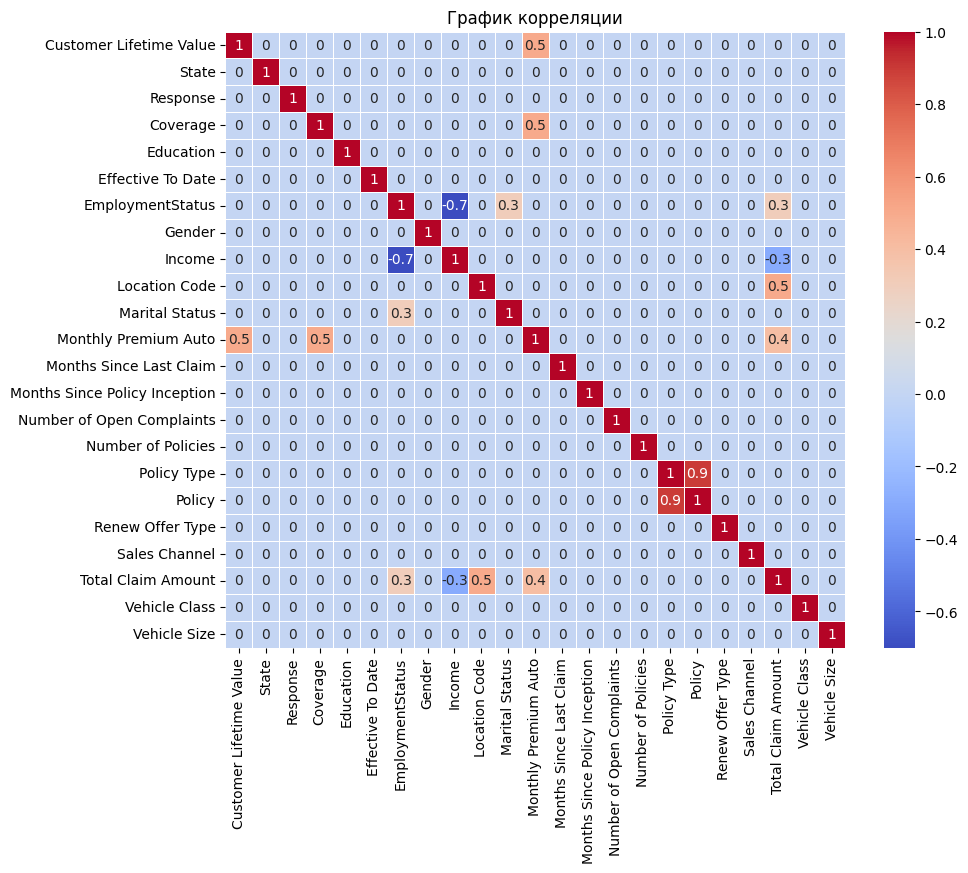

In [156]:
# Построим график корреляции
corr_matrix = all_data.corr()
corr_matrix = np.round(corr_matrix, 1)
corr_matrix[np.abs(corr_matrix)<0.3] = 0
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, linewidths=0.5, cmap='coolwarm')
plt.title('График корреляции');

### Вывод:
`Customer Lifetime Value` коррелирует с `Monthly Premium Auto`, с увеличением `Customer Lifetime Value` увеличивается `Monthly Premium Auto`.